In [2]:
# libraries for data preparation and visualizations
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# import plotly.express as px
# import seaborn as sns
# sns.set_theme()

# Ignore printing warnings for general readability
import warnings 
warnings.filterwarnings("ignore")

# Library to split data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# To build model for prediction
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# To get diferent metric scores
from sklearn.metrics import  mean_squared_error, r2_score



---



---



> Indented block



# Problem Statement

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:
 

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.

In [ ]:
 center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

# Load Data in dataframe

Build one dataframe by inner merging to get useful informations that we can

In [ ]:
# Merge train_data with center_info 
data = pd.merge(train_data, center_info, how='inner', on='center_id')
# Merge data with meal_info
data = pd.merge(data, meal_info, how='inner', on='meal_id').sort_values(by=['week'])

data

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
299714,1102584,1,11,1525,242.50,282.33,0,1,460,679,56,TYPE_A,3.7,Other Snacks,Thai
299851,1026447,1,83,1525,244.50,281.33,0,0,94,659,77,TYPE_A,5.3,Other Snacks,Thai
299996,1177435,1,32,1525,249.29,251.29,0,0,82,526,34,TYPE_A,3.8,Other Snacks,Thai
31140,1108310,1,43,2539,133.86,135.86,0,0,675,590,56,TYPE_A,5.1,Beverages,Thai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364068,1126639,145,39,1247,446.23,446.23,0,0,14,526,34,TYPE_C,3.8,Biryani,Indian
243852,1476913,145,75,1558,548.08,549.08,0,0,175,651,77,TYPE_B,4.7,Pizza,Continental
130329,1193828,145,97,2290,272.60,271.60,0,0,473,628,77,TYPE_A,4.6,Rice Bowl,Indian
26604,1188974,145,27,2539,158.14,158.14,0,0,244,713,85,TYPE_A,4.5,Beverages,Thai


For our ML part, I things that column ID is useless because it is just a random number it doesn't give us any real informaion concerning our business.

In [ ]:
data_ = data.drop('id', axis= 1) 

In [ ]:
data_.shape

(456548, 14)

In our dataframe data_, we have 3 categorical values we need to encode those.

In [ ]:
df = pd.get_dummies(data_)

In [ ]:
df

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1,55,1885,136.83,152.29,0,0,177,647,56,...,0,0,0,0,0,0,0,0,0,1
299714,1,11,1525,242.50,282.33,0,1,460,679,56,...,0,0,0,0,0,0,0,0,0,1
299851,1,83,1525,244.50,281.33,0,0,94,659,77,...,0,0,0,0,0,0,0,0,0,1
299996,1,32,1525,249.29,251.29,0,0,82,526,34,...,0,0,0,0,0,0,0,0,0,1
31140,1,43,2539,133.86,135.86,0,0,675,590,56,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364068,145,39,1247,446.23,446.23,0,0,14,526,34,...,0,0,0,0,0,0,0,1,0,0
243852,145,75,1558,548.08,549.08,0,0,175,651,77,...,0,0,0,0,0,0,1,0,0,0
130329,145,97,2290,272.60,271.60,0,0,473,628,77,...,1,0,0,0,0,0,0,1,0,0
26604,145,27,2539,158.14,158.14,0,0,244,713,85,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.shape

(456548, 32)

# Base model:
    In our case, we have a supervised regression ML problem because we already have the label and this label are continous values. We have around 450k rows, we should choice a ML algorithm which doesn't take a lot memory.
    Then our base model will be Linear regression. As we have numerical values with a plage of 1 to 2200 we should scaled for convience.

In [ ]:
X = df.drop('num_orders', axis= 1)
y = df['num_orders']

In [ ]:
# Split the data into training & testing sets

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
# Using Mean squared error with no Model validation

pipe = Pipeline([('scaling', StandardScaler()),('lr', LinearRegression())])

%time pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

y_train_full_pred = pipe.predict(X_train_full)

# %%time
mean_squared_error(y_train_full, y_train_full_pred)

CPU times: user 1.09 s, sys: 425 ms, total: 1.52 s
Wall time: 1.27 s


93818.77291559611

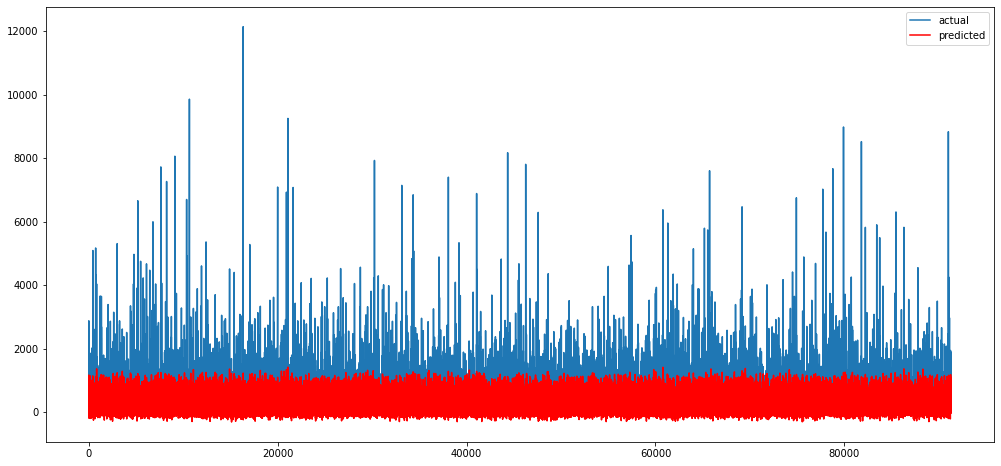

In [ ]:

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt

predictions = pipe.predict(X_test)

plt.figure(figsize=(17, 8))
plt.plot(range(len(y_test)),y_test, label="actual")
plt.plot(range(len(predictions)),predictions, color='red', label="predicted")
plt.legend(loc='best')

plt.show()

### Data Dictionary

Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable
 
Variable|	Definition
---| ---
id|	Unique ID
week|	Week No
center_id|	Unique ID for fulfillment center
meal_id|	Unique ID for Meal
checkout_price|	Final price including discount, taxes & delivery charges
base_price|	Base price of the meal
emailer_for_promotion|	Emailer sent for promotion of meal
homepage_featured|	Meal featured at homepage
num_orders|	(Target) Orders Count

fulfilment_center_info.csv: Contains information for each fulfilment center
 
Variable|	Definition
---| ---
center_id|	Unique ID for fulfillment center
city_code|	Unique code for city
region_code|	Unique code for region
center_type|	Anonymized center type
op_area|	Area of operation (in km^2)

meal_info.csv: Contains information for each meal being served
 
Variable|	Definition
---| ---
meal_id|	Unique ID for the meal
category|	Type of meal (beverages/snacks/soups….)
cuisine|	Meal cuisine (Indian/Italian/…) 

# Model selection

    - For the linear regression, we got Root mean squared error of 334.86, with time of 850 ms. The time represents the best time score of all methods
    - With a training time of 1m 47s,the Random Forest is the slowest model. Meanwhile, we got a Root mean squared error of 212.09 which more far better than the linear regression 
    - With a Root mean squared error of 149.17, extreme gradient bosting is better algorithm. In addition, it  has a training time of 22.3 s. Hence, Xgboost become our best model. 
    
    So let use Xgboost

In [ ]:
models = [('Linear Regression', LinearRegression()),
          ("Random forest", RandomForestRegressor(n_estimators= 100, random_state= 0, n_jobs= -1)),
          ("Xgboost", xgb.XGBRegressor(objective= "reg:linear", random_state= 42, n_jobs= -1)),
         ]

results  = []  
names    = []  


# loop through models & calculate mean squared error               
for name, model in models:
    
    pipe = Pipeline([
                    #('scaling', StandardScaler()),
                    (name, model)
                    ])

    %time pipe.fit(X_train_full, y_train_full)

    Pipeline(steps=[('scaler', StandardScaler()), (name, model)])

    y_test_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_test_pred)
             
    
    names.append(name)
    results.append(mse)
           
    print(f'{name} : {mse}')

CPU times: user 983 ms, sys: 248 ms, total: 1.23 s
Wall time: 918 ms
Linear Regression : 86561.73648355712
CPU times: user 6min 56s, sys: 4.09 s, total: 7min
Wall time: 3min 59s
Random forest : 18979.297820198222
[06:48:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 7s, sys: 298 ms, total: 2min 7s
Wall time: 1min 10s
Xgboost : 21469.50891176542


# Hyperparameter tunning

model = xgb.XGBRegressor(objective= "reg:linear",max_depth= 10, booster= 'gbtree', random_state= 42, n_jobs= -1)

In [ ]:
# Xgboost
# I tryied it in differents ways because my computer wasn't able to handle the GridSearch.
# I try the booster first then themax depth and so forth

pipe_Xgb  = Pipeline(
                    [('Scaling' , StandardScaler()),
                     ('Xgboost', xgb.XGBRegressor(objective= "reg:linear", random_state= 42, n_jobs= -1))
                    ])

parameters = {
            #'Xgboost__booster' : ['gbtree','gblinear', 'dart'],
            'Xgboost__max_depth'  : [10, 15, 20],
            #'Xgboost__n_estimators'  : [10, 20, 30, 40],
            #'Xgboost__learning_rate': [1.0,0.1,0.01]
             }

gs_Xgb  = GridSearchCV(pipe_Xgb, parameters, scoring='neg_mean_squared_error',cv=3, n_jobs=-1)

gs_Xgb.fit(X_train_full, y_train_full)

[07:11:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Scaling', StandardScaler()),
                                       ('Xgboost',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_typ...
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     objective='reg:linear',
                                                     predictor=None, ...))]),
             n_jobs=-1, param_grid={'Xgboost__max_depth': [10, 15, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
gs_Xgb.best_params_

{'Xgboost__max_depth': 10}

In [ ]:
Xgb_tuned = gs_Xgb.best_estimator_

In [ ]:
%time Xgb_tuned.fit(X_train_full, y_train_full)

y_train_full_pred = Xgb_tuned.predict(X_train_full)

mean_squared_error(y_train_full, y_train_full_pred)


[07:13:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 47s, sys: 515 ms, total: 3min 48s
Wall time: 2min 5s


5856.058454235908

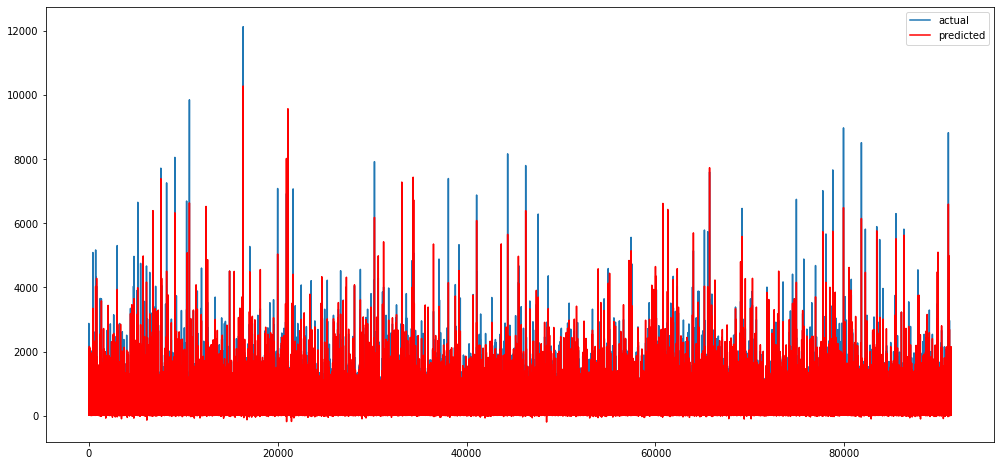

In [ ]:
predictions = Xgb_tuned.predict(X_test)

plt.figure(figsize=(17, 8))
plt.plot(range(len(y_test)),y_test, label="actual")
plt.plot(range(len(predictions)),predictions, color='red', label="predicted")
plt.legend(loc='best')

plt.show()

# Features importance

In [ ]:
#The Xgb_tuned has the a pipeline so it can't run a feature importance so I use only the Xgboost

# xgb.plot_importance(Xgb_tuned())

In [ ]:
model = xgb.XGBRegressor(objective= "reg:linear",max_depth= 10, booster= 'gbtree', random_state= 42, n_jobs= -1)

%time model.fit(X_train_full, y_train_full)

y_test_pred = model.predict(X_test)

mean_squared_error(y_test, y_test_pred)

[07:15:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 52s, sys: 530 ms, total: 3min 53s
Wall time: 2min 9s


15327.436634246547

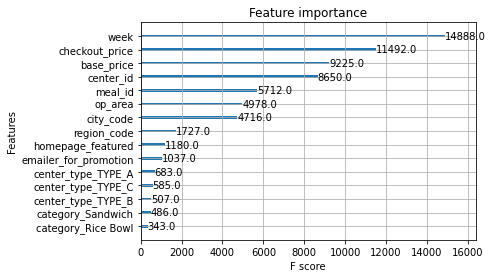

In [ ]:
xgb.plot_importance(model,max_num_features=15); 

In [ ]:
model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)>

# Predictions

In [ ]:
training = data.loc[:, ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders']]

In [ ]:
X_train = training.drop(['num_orders'], axis=1).values
y_train = training['num_orders'].values

In [ ]:
X_test = test_data.values

In [ ]:
xgb_model = xgb.XGBRegressor(objective= "reg:linear",max_depth= 10, booster= 'gbtree', random_state= 42, n_jobs= -1)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

[07:18:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
ypred = pd.DataFrame(y_pred,columns= ['num_orders'])
ypred

,num_orders
0,599.845093
1,36.670868
2,134.886536
3,-11.229849
4,-0.884997
...,...
32568,67.270477
32569,32.293236
32570,274.105560
32571,318.910492


In [ ]:
predictions = pd.merge(test_data, ypred, left_index=True, right_index=True, how='inner')
predictions

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,599.845093
1,1127204,146,55,1993,160.11,159.11,0,0,36.670868
2,1212707,146,55,2539,157.14,159.14,0,0,134.886536
3,1082698,146,55,2631,162.02,162.02,0,0,-11.229849
4,1400926,146,55,1248,163.93,163.93,0,0,-0.884997
...,...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0,67.270477
32569,1039516,155,61,2304,483.09,483.09,0,0,32.293236
32570,1158107,155,61,2664,322.07,323.07,0,0,274.105560
32571,1444235,155,61,2569,322.07,323.07,0,0,318.910492


In [ ]:
ts_tot_orders = data.groupby(['week'])['num_orders'].sum()
ts_tot_orders = pd.DataFrame(ts_tot_orders)
ts_tot_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [ ]:
ts_tot_pred = predictions.groupby(['week'])['num_orders'].sum()
ts_tot_pred = pd.DataFrame(ts_tot_pred)

In [3]:
import plotly.graph_objs as go
import plotly.offline as pyoff
plot_data = [
    go.Scatter(
        x=ts_tot_orders.index,
        y=ts_tot_orders['num_orders'],
        name='Time Series for num_orders',
        marker = dict(color = 'Blue')
        #x_axis="OTI",
        #y_axis="time",
    ),
    go.Scatter(
        x=ts_tot_predictions.index,
        y=ts_tot_predictions ['num_orders'],
        name='Predicted',  
]
plot_layout = go.Layout(
        title='Total orders per week',
        yaxis_title='Total orders',
        xaxis_title='Week',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

NameError: name 'ts_tot_orders' is not defined

Main Front end

In [ ]:
def main1(f1,f2,f3,f4):
  center_info = pd.read_csv(f1)
  meal_info = pd.read_csv(f2)
  test_data = pd.read_csv(f3)
  train_data = pd.read_csv(f4)
  # Merge train_data with center_info 
  data = pd.merge(train_data, center_info, how='inner', on='center_id')
  # Merge data with meal_info
  data = pd.merge(data, meal_info, how='inner', on='meal_id').sort_values(by=['week'])
  data_ = data.drop('id', axis= 1) 
  df = pd.get_dummies(data_)
  X = df.drop('num_orders', axis= 1)
  y = df['num_orders']
  X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
  # Xgboost
  # I tryied it in differents ways because my computer wasn't able to handle the GridSearch.
  # I try the booster first then themax depth and so forth

  pipe_Xgb  = Pipeline(
                      [('Scaling' , StandardScaler()),
                      ('Xgboost', xgb.XGBRegressor(objective= "reg:linear", random_state= 42, n_jobs= -1))
                      ])

  parameters = {
              #'Xgboost__booster' : ['gbtree','gblinear', 'dart'],
              'Xgboost__max_depth'  : [10, 15, 20],
              #'Xgboost__n_estimators'  : [10, 20, 30, 40],
              #'Xgboost__learning_rate': [1.0,0.1,0.01]
              }

  gs_Xgb  = GridSearchCV(pipe_Xgb, parameters, scoring='neg_mean_squared_error',cv=3, n_jobs=-1)

  gs_Xgb.fit(X_train_full, y_train_full)
  Xgb_tuned = gs_Xgb.best_estimator_
  %time Xgb_tuned.fit(X_train_full, y_train_full)

  y_train_full_pred = Xgb_tuned.predict(X_train_full)

  mean_squared_error(y_train_full, y_train_full_pred)
  predictions = Xgb_tuned.predict(X_test)

  plt.figure(figsize=(17, 8))
  plt.plot(range(len(y_test)),y_test, label="actual")
  plt.plot(range(len(predictions)),predictions, color='red', label="predicted")
  plt.legend(loc='best')

  plt.savefig('main.png')
  return "main.png"

In [ ]:
!pip install gradio

In [ ]:
def gmain(file1,file2,file3,file4):
  rn=main1(file1.name,file2.name,file3.name,file4.name)
  return rn

import gradio as gr
g=gr.Interface(gmain,inputs=["file","file","file","file"],outputs="image",capture_session=True)
g.launch(debug=True,share=True)

FRONT END

In [ ]:
def main(f1,f2,f3,f4):
  center_info = pd.read_csv(f1)
  meal_info = pd.read_csv(f2)
  test_data = pd.read_csv(f3)
  train_data = pd.read_csv(f4)
  # Merge train_data with center_info 
  data = pd.merge(train_data, center_info, how='inner', on='center_id')
  # Merge data with meal_info
  data = pd.merge(data, meal_info, how='inner', on='meal_id').sort_values(by=['week'])
  data_ = data.drop('id', axis= 1) 
  df = pd.get_dummies(data_)
  X = df.drop('num_orders', axis= 1)
  y = df['num_orders']
  X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
  # Xgboost
  # I tryied it in differents ways because my computer wasn't able to handle the GridSearch.
  # I try the booster first then themax depth and so forth

  pipe_Xgb  = Pipeline(
                      [('Scaling' , StandardScaler()),
                      ('Xgboost', xgb.XGBRegressor(objective= "reg:linear", random_state= 42, n_jobs= -1))
                      ])

  parameters = {
              #'Xgboost__booster' : ['gbtree','gblinear', 'dart'],
              'Xgboost__max_depth'  : [10, 15, 20],
              #'Xgboost__n_estimators'  : [10, 20, 30, 40],
              #'Xgboost__learning_rate': [1.0,0.1,0.01]
              }

  gs_Xgb  = GridSearchCV(pipe_Xgb, parameters, scoring='neg_mean_squared_error',cv=3, n_jobs=-1)

  gs_Xgb.fit(X_train_full, y_train_full)
  Xgb_tuned = gs_Xgb.best_estimator_
  %time Xgb_tuned.fit(X_train_full, y_train_full)

  y_train_full_pred = Xgb_tuned.predict(X_train_full)

  mean_squared_error(y_train_full, y_train_full_pred)
  predictions = Xgb_tuned.predict(X_test)

  plt.figure(figsize=(17, 8))
  plt.plot(range(len(y_test)),y_test, label="actual")
  plt.plot(range(len(predictions)),predictions, color='red', label="predicted")
  plt.legend(loc='best')

  plt.show()
  return "0"

In [ ]:
!pip install gradio

In [ ]:
def gmain(file1,file2,file3,file4):
  main(file1.name,file2.name,file3.name,file4.name)
  return "0"

import gradio as gr
g=gr.Interface(gmain,inputs=["file","file","file","file"],outputs="text",capture_session=True)
g.launch(debug=True,share=True)